# MiBiReMo Example 3: BTEX dissolution and 1D transport coupling

Implements Sequential Non-Iterative Approach (SNIA) coupling:
1. Advective and dispersive transport: Custom 1D solver based on Semi-Lagrangian method
2. Reaction: PhreeqcRM

Compares two simulation types:
- Equilibrium dissolution (NAPL as equilibrium phases)
- Kinetic dissolution (NAPL kinetic dissolution)

Author: Matteo Masi  
Last revision: 17/02/2026

In [ ]:
import time
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import mibiremo
from importlib.resources import files

### Simulation settings
In this section, the main parameters for the simulation are defined, including the initial conditions, reaction parameters, and simulation options.
The database used here is `mibirem.dat`, which contains the necessary reaction kinetics fot the BTEX compounds. In this simulation we use only one cell, like having a single well-mixed batch reactor.


In [ ]:
database_path = str(files("mibiremo").joinpath("database/mibirem.dat"))  # Database path
pqi_eq = "pqi/ex3_BTEX_dissolution_and_transport_coupling_eq.pqi"  # Equilibrium input
pqi_kin = "pqi/ex3_BTEX_dissolution_and_transport_coupling_kin.pqi"  # Kinetics input
sel_file = "pqi/ex3_BTEX_dissolution_and_transport.sel"  # PHREEQC results

# Model parameters
n_cells = 1000  # Number of model cells
dt = 0.1  # Coupling time step (days)
domain_length = 100.0  # Length of domain (m)
n_threads = 6  # Threads for calculation (-1 for all CPUs)
dispersivity = 0.05  # Dispersivity (m²)
velocity = 1.0  # Groundwater velocity (m/d)
diffusion_coeff = 0.0  # Molecular diffusion (m²/s)
sim_duration = 100.0  # Simulation duration (days)

# Physical properties
unit_solution = 2  # 1: mg/L; 2: mol/L; 3: kg/kgs
units = 1  # 0: mol/L cell; 1: mol/L water; 2: mol/L rock
porosity = 1.0  # Porosity
saturation = 1.0  # Saturation

# Monitoring
probe_location = 49.75  # Probe location (m) for results extraction

# Derived parameters
dispersion_coeff = dispersivity * velocity  # Dispersion coefficient (m²/d)
n_steps = int(sim_duration / dt)  # Number of time steps
contaminant_spot = int(0.5 * n_cells / domain_length)  # Contaminant spot size

### Coupled transport-reaction simulation function
In the function below, the coupled transport-reaction simulation is defined. It initializes the PhreeqcRM object, sets up the transport solver, and runs the simulation for both equilibrium and kinetic dissolution scenarios.

In [3]:
def run_simulation(pqi_file, kinetic=False):
    """Run coupled transport-reaction simulation.
    
    Args:
        pqi_file: Path to Phreeqc input file
        kinetic: Whether to run kinetic dissolution (default: equilibrium)
    Returns:
        Tuple of (time vector, concentration results at probe location)
    """
    # Initialize PhreeqcRM
    phr = mibiremo.PhreeqcRM()
    phr.create(nxyz=n_cells, n_threads=n_threads)
    phr.initialize_phreeqc(database_path, unit_solution, units, porosity, saturation)

    # Prepare the initial conditions
    ic = [2,-1,-1,-1,-1,-1,-1]
    ic = np.tile(ic, (n_cells, 1))

    # Contaminated spot 0.5 m
    spot = int(0.5 * n_cells / domain_length)
    ic[0:spot, 0] = 1  # Contaminant spot
    if kinetic:
        ic[0:spot, 6] = 1 # Kinetics
    else:
        ic[0:spot, 1] = 1 # Equilibrium phases

    # Run initial conditions in PhreeqcRM
    phr.run_initial_from_file(pqi_file, ic)

    # Get components and species
    components = phr.components
    n_comps = len(components)

    # Get initial concentrations
    cc = np.zeros(n_cells * n_comps, dtype=np.float64)
    phr.rm_get_concentrations(cc)

    # Prepare monitoring
    monitored_species = ["Benz", "Ethyl"]
    species_map = np.zeros(len(monitored_species), dtype=np.int32)
    for i, s in enumerate(monitored_species):
        species_map[i] = np.where(components == s)[0][0]

    # Initialize results storage
    time_vector = np.zeros(n_steps)
    concentration_results = np.zeros((n_steps, len(monitored_species)))

    # Space vector and probe location
    x_coords = np.linspace(0, domain_length, n_cells)
    probe_idx = np.argmin(np.abs(x_coords - probe_location))

    # Store initial concentrations
    conc_matrix = cc.reshape((n_comps, n_cells)).T
    concentration_results[0, :] = conc_matrix[probe_idx, species_map]

    # Boundary condition
    left_boundary_conc = 0.0

    # Main simulation loop
    start_time = time.time()
    for step in range(1, n_steps):
        current_time = step * dt
        time_vector[step] = current_time

        # 1) Reactive step
        phr.rm_set_time(current_time * 3600 * 24)  # Convert to seconds
        phr.rm_set_time_step(dt * 3600 * 24)
        phr.rm_run_cells()
        phr.rm_get_concentrations(cc)
        conc_matrix = cc.reshape((n_comps, n_cells)).T

        # 2) Transport step
        for j in range(len(monitored_species)):
            solver = mibiremo.SemiLagSolver(
                x_coords,
                conc_matrix[:, species_map[j]],
                velocity,
                dispersion_coeff,
                dt
            )
            transported_conc = solver.transport(left_boundary_conc)

            # Store and update concentrations
            concentration_results[step, j] = transported_conc[probe_idx]
            conc_matrix[:, species_map[j]] = transported_conc

        # Update concentrations in PhreeqcRM
        cc = conc_matrix.T.flatten()
        phr.rm_set_concentrations(cc)

    elapsed = time.time() - start_time
    print(f"Simulation completed in {elapsed:.2f} seconds")

    return time_vector, concentration_results

### Plotting function

In [4]:
def plot_results(time_eq, conc_eq, time_kin, conc_kin, phreeqc_results):
    """Plot and compare simulation results."""
    # Process PHREEQC results
    phreeqc_results.columns = phreeqc_results.columns.str.replace(" ", "")
    transport_data = phreeqc_results[phreeqc_results["state"].str.contains("transp")]

    # Create plot
    plt.figure(figsize=(10, 4))

    # Plot PHREEQC results
    plt.plot(
        transport_data["time"] / 3600 / 24,
        transport_data["Benz"] * 1e3 * 78.114,
        label="Benzene - PHREEQC - equilibrium",
        linestyle="None",
        marker="o",
        markersize=8,
        markerfacecolor="none",
    )
    plt.plot(
        transport_data["time"] / 3600 / 24,
        transport_data["Ethyl"] * 1e3 * 106.17,
        label="Ethylbenzene - PHREEQC - equil.",
        linestyle="None",
        marker="^",
        markersize=8,
        markerfacecolor="none",
    )

    # Plot equilibrium dissolution results
    plt.plot(
        time_eq,
        conc_eq[:, 0] * 78.114 * 1000,
        label="Benzene - MIBIREMO - equilibrium"
    )
    plt.plot(
        time_eq,
        conc_eq[:, 1] * 106.17 * 1000,
        label="Ethylbenzene - MIBIREMO - equil."
    )

    # Plot kinetic dissolution results
    plt.plot(
        time_kin,
        conc_kin[:, 0] * 78.114 * 1000,
        label="Benzene - MIBIREMO - kinetics",
        linestyle="--"
    )
    plt.plot(
        time_kin,
        conc_kin[:, 1] * 106.17 * 1000,
        label="Ethylbenzene - MIBIREMO - kinetics",
        linestyle="--"
    )

    # Configure plot
    plt.xlabel("Time (days)")
    plt.ylabel("Aqueous concentration (mg/L)")
    plt.legend()
    plt.title(
        "BTEX dissolution and transport at 50 m distance from the source\n"
        "Equilibrium vs kinetics comparison",
        fontsize=10
    )
    plt.tight_layout()
    plt.show()

### Run simulations and plot results
The reactive-transport of BTEX compounds in a 1D domain is simulated using the MiBiReMo framework. The simulation considers the dissolution of a non-aqueous phase liquid (NAPL) containing BTEX compounds into the aqueous phase.
Two simulations are compared: one assuming istantaneous dissolution (equilibrium assumption) and the other considering kinetic dissolution of the NAPL phase. The results of the equilibrium dissolution are plotted against simulations obtained with standalone PHREEQC (with TRANSPORT keyword) to validate the results.
When the kinetic dissolution is considered, the results show a slower increase in the concentration of BTEX compounds in the aqueous phase, reflecting the kinetic limitations of the dissolution process.

Running equilibrium dissolution simulation...
Simulation completed in 13.72 seconds

Running kinetic dissolution simulation...
Simulation completed in 13.89 seconds


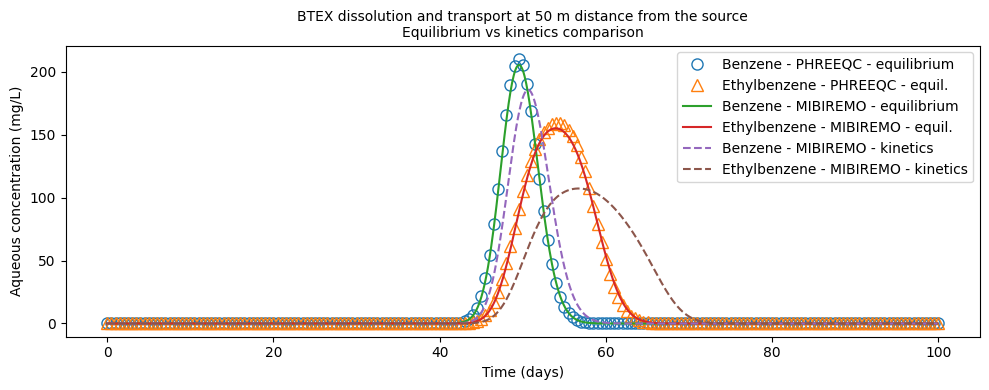

In [5]:
# Run equilibrium simulation
print("Running equilibrium dissolution simulation...")
time_eq, conc_eq = run_simulation(pqi_eq)

# Run kinetic simulation
print("\nRunning kinetic dissolution simulation...")
time_kin, conc_kin = run_simulation(pqi_kin, kinetic=True)

# Load PHREEQC results for comparison
phreeqc_results = pd.read_csv(sel_file, sep="\t")

# Plot results
plot_results(time_eq, conc_eq, time_kin, conc_kin, phreeqc_results)